## Classification with Python

Hopefully now you are feeling a bit more comfortable with Python, Kaggle, and modeling. 

The next kaggle project:

https://www.kaggle.com/c/costa-rican-household-poverty-prediction

### Grading

This homework is due **March 14, 2019 by 4:00 pm Utah time.** By that time, you need to have committed all your code to your github and submitted a link to your work to the TA. We can see on your Github account when you last committed code. :)

Rubric:

* Code Quality - 10%
* Storytelling - 10%
* Result on Kaggle - 5%
* Describing, Cleaning, and Visualizing data - 25%
* Modeling - 50%

More specifically, for modeling we will look for: 

* Model Selection: Did you try multiple models? Why did you choose these models? How do they work? What are they assumptions? And how did you test/account for them? How did you select hyper-parameters?
* Model evaluation: Did you evaluate your model on multiple metrics? Where does your model do well? Where could it be improved? How are the metrics different?
* Model interpretation: What do the model results tell you? Which variables are important? High bias or variance and how did you / could you fix this? How confident are you in your results? 
* Model usefulness: Do you think your final model was useful? If so, how would you recommend using it? Convince us, that if we were a company, we would feel comfortable using your model with our users. Think about edge cases as well - are there certain areas that the model performs poorly on? Best on? How would you handle these cases, if say Zillow wanted to leverage your model realizing that bad recommendations on sale prices would hurt customer trust and your brand. This section also falls into the storytelling aspect of the grading.

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, roc_auc_score

In [53]:
#Load the data
data_train = pd.read_csv('train_costarica.csv')
data_test = pd.read_csv('test_costarica.csv')
data_train.columns

Index(['Id', 'v2a1', 'hacdor', 'rooms', 'hacapo', 'v14a', 'refrig', 'v18q',
       'v18q1', 'r4h1',
       ...
       'SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 'SQBhogar_nin',
       'SQBovercrowding', 'SQBdependency', 'SQBmeaned', 'agesq', 'Target'],
      dtype='object', length=143)

In [54]:
#Save the 'Id' column
train_ID = data_train['Id']
test_ID = data_test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
data_train.drop("Id", axis = 1, inplace = True)
data_test.drop("Id", axis = 1, inplace = True)

In [55]:
data_train.head()

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,190000.0,0,3,0,1,1,0,NaN,0,1,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,135000.0,0,4,0,1,1,1,1.0,0,1,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,NaN,0,8,0,1,1,0,NaN,0,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,180000.0,0,5,0,1,1,1,1.0,0,2,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,180000.0,0,5,0,1,1,1,1.0,0,2,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [56]:
#Get the top columns with missing values
missmap = data_train.isnull().sum().to_frame()
missmap = missmap.sort_values(0, ascending = False)
missmap.head()

,0
rez_esc,7928
v18q1,7342
v2a1,6860
SQBmeaned,5
meaneduc,5


In [57]:
#Feature engineering function I found online
def do_features(df):
    feats_div = [('children_fraction', 'r4t1', 'r4t3'), 
                 ('working_man_fraction', 'r4h2', 'r4t3'),
                 ('all_man_fraction', 'r4h3', 'r4t3'),
                 ('human_density', 'tamviv', 'rooms'),
                 ('human_bed_density', 'tamviv', 'bedrooms'),
                 ('bed_density', 'bedrooms', 'rooms'),
                 ('rent_per_person', 'v2a1', 'r4t3'),
                 ('rent_per_room', 'v2a1', 'rooms'),
                 ('mobile_density', 'qmobilephone', 'r4t3'),
                 ('tablet_density', 'v18q1', 'r4t3'),
                 ('mobile_adult_density', 'qmobilephone', 'r4t2'),
                 ('tablet_adult_density', 'v18q1', 'r4t2'),
                 ('male_over_female', 'r4h3', 'r4m3'),
                 ('man12plus_over_women12plus', 'r4h2', 'r4m2'),
                 ('pesioner_over_working', 'hogar_mayor', 'hogar_adul'),
                 ('children_over_working', 'hogar_nin', 'hogar_adul'),
                 ('education_fraction', 'escolari', 'age')
                 #('', '', ''),
                ]
    
    feats_sub = [('people_not_living', 'tamhog', 'tamviv'),
                 ('non_bedrooms', 'rooms', 'bedrooms'),
                 ('people_weird_stat', 'tamhog', 'r4t3')]

    for f_new, f1, f2 in feats_div:
        df['fe_' + f_new] = (df[f1] / df[f2]).astype(np.float32)       
    for f_new, f1, f2 in feats_sub:
        df['fe_' + f_new] = (df[f1] - df[f2]).astype(np.float32)
    
    # aggregation rules over household
    aggs_num = {'age': ['min', 'max', 'mean', 'count'],
                'escolari': ['min', 'max', 'mean', 'std'],
                'fe_education_fraction': ['min', 'max', 'mean', 'std']
               }
    aggs_cat = {'dis': ['mean']}
    for s_ in ['estadocivil', 'parentesco', 'instlevel']:
        for f_ in [f_ for f_ in df.columns if f_.startswith(s_)]:
            aggs_cat[f_] = ['mean']
    # aggregation over household
    for name_, df_ in [('18', df.query('age >= 18'))]:
        df_agg = df_.groupby('idhogar').agg({**aggs_num, **aggs_cat}).astype(np.float32)
        df_agg.columns = pd.Index(['agg' + name_ + '_' + e[0] + "_" + e[1].upper() for e in df_agg.columns.tolist()])
        df = df.join(df_agg, how='left', on='idhogar')
        del df_agg
    # do something advanced above...
    
    # Drop SQB variables, as they are just squres of other vars 
    df.drop([f_ for f_ in df.columns if f_.startswith('SQB') or f_ == 'agesq'], axis=1, inplace=True)
    # Drop repeated columns
    df.drop(['hhsize', 'female', 'area2'], axis=1, inplace=True)
    return df

In [58]:
#This function replaces null values with -1 and 0 values depending on variable
def process_df(df_):
    for f in ['v2a1', 'v18q1', 'meaneduc', 'SQBmeaned']:
        df_[f] = df_[f].fillna(0)
    df_['rez_esc'] = df_['rez_esc'].fillna(-1)
    return (df_)

#Run function on training and testing data
data_train = process_df(data_train)
data_test = process_df(data_test)

In [59]:
#Save X and Y and drop the Id from x
#y = train['Target']
#X = train.drop(['Target'], axis=1).copy()

#combine the training and testing data
all_data = pd.concat((data_train.drop(['Target'], axis=1), data_test))

In [60]:
#Create dummy variables for all the categorical features
all_data = pd.get_dummies(all_data)

In [61]:
#We will now create our training and testing data again
train = all_data[:data_train.shape[0]]
test = all_data[data_train.shape[0]:]

In [62]:
#Save X and Y and drop the Id from x
y = data_train['Target']
X = train

In [63]:
#Get an overview of the data
y.describe()

count    9557.000000
mean        3.302292
std         1.009565
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         4.000000
Name: Target, dtype: float64

In [64]:
#See the distribution of y
y.value_counts(normalize=True)

4    0.627394
2    0.167103
3    0.126504
1    0.079000
Name: Target, dtype: float64

(array([   0.,  755., 1597., 1209., 5996.,    0.]),
 array([0, 1, 2, 3, 4, 5, 6]),
 <a list of 6 Patch objects>)

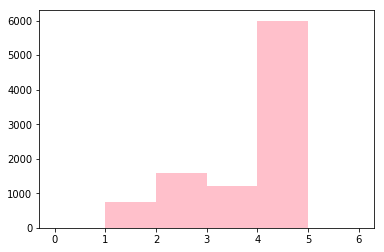

In [65]:
#Here we can visually see the distribution of y
plt.hist(y, bins=[0,1,2,3,4,5,6], color='pink')

In [66]:
#View the 20 most correlated variables
#abs(train.corr()['Target']).sort_values(ascending=False)[0:20]

###### None of the variables were highly correlated 

In [67]:
x_tr, x_val, y_tr, y_val = train_test_split(X, y, test_size=.2, random_state=42)

In [68]:
#Now we will create a random forest
param_dictionary = {"n_estimators": [100, 500, 1000]}
RFC = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=3)
gs = GridSearchCV(RFC, param_dictionary, n_jobs=1, verbose=2, cv=2)
gs.fit(x_tr, y_tr)

Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................. n_estimators=100, total=   4.5s
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.0s remaining:    0.0s


[CV] ................................. n_estimators=100, total=   1.6s
[CV] n_estimators=500 ................................................
[CV] ................................. n_estimators=500, total=   2.3s
[CV] n_estimators=500 ................................................
[CV] ................................. n_estimators=500, total=   2.2s
[CV] n_estimators=1000 ...............................................
[CV] ................................ n_estimators=1000, total=   3.2s
[CV] n_estimators=1000 ...............................................
[CV] ................................ n_estimators=1000, total=   3.1s


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   20.3s finished


GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=3, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators='warn', n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'n_estimators': [100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [69]:
#I was curious to see which was best but since it is random each time the "best" parameter is different.
gs.best_params_

{'n_estimators': 500}

In [70]:
#get the predictions and training scores for x_tr
train_predictions = gs.predict(x_tr)
cr = classification_report(y_tr, train_predictions)
print("Training Scores:")
print(cr)
print("-"*50)

Training Scores:
              precision    recall  f1-score   support

           1       0.31      0.64      0.42       591
           2       0.43      0.32      0.37      1286
           3       0.33      0.33      0.33       955
           4       0.83      0.77      0.80      4813

   micro avg       0.63      0.63      0.63      7645
   macro avg       0.48      0.52      0.48      7645
weighted avg       0.66      0.63      0.64      7645

--------------------------------------------------


In [71]:
#get the predictions and training scores for x_val
val_predictions = gs.predict(x_val)
cr = classification_report(y_val, val_predictions)
print('Validation Scores:')
print(cr)
print('-'*50)

Validation Scores:
              precision    recall  f1-score   support

           1       0.33      0.63      0.44       164
           2       0.43      0.31      0.36       311
           3       0.31      0.27      0.29       254
           4       0.82      0.79      0.81      1183

   micro avg       0.63      0.63      0.63      1912
   macro avg       0.47      0.50      0.47      1912
weighted avg       0.65      0.63      0.63      1912

--------------------------------------------------


In [72]:
#look at feature importances for our model after training it
feat_imports = sorted(list(zip(X.columns, gs.best_estimator_.feature_importances_)), key=lambda x:x[1], reverse=True)
feat_imports[0:10]

[('meaneduc', 0.02563936373134907),
 ('eviv3', 0.021097471270354645),
 ('SQBmeaned', 0.019948170301993827),
 ('instlevel8', 0.01936029535000196),
 ('SQBedjefe', 0.01840844329830974),
 ('etecho3', 0.018111453036661018),
 ('SQBhogar_nin', 0.018013393080849434),
 ('epared3', 0.017704978405413904),
 ('SQBescolari', 0.017474754292521193),
 ('cielorazo', 0.017470463733033202)]

In [73]:
#train the model on all of our data
clf = RandomForestClassifier(n_jobs=-1, max_depth=5, n_estimators=1000, class_weight='balanced', verbose=1)
clf.fit(X, y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.9s finished


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=-1, oob_score=False,
            random_state=None, verbose=1, warm_start=False)

In [74]:
#get test predictions
test_predictions = clf.predict(pd.get_dummies(test))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.6s finished


In [75]:
#Error Analysis
probabilities = clf.predict_proba(test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.5s finished


In [76]:
#Create submission
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['Target'] = test_predictions
sub.to_csv('costarica1.csv',index=False)

# Final Thoughts

##### I enjoyed this competition but honestly I wish I would have had more time to work on it.  I have been slammed with midterms the past two weeks and to top it off I got crazy sick this week.  So I have not been able to put in the time or energy I would've like to into this assignment.  If I had the time (or the health) I would've spent much more time trying different models and trying to find the one that best predicted the data.  So instead after trying a few different models, I decided to use a Random Forest because we had talked about it in class and how it is a good "go-to" model.  Since I had never used one before, I thought this would be the perfect assignment to use a Random Forest on.  I really enjoyed practicing what we learned in class.  I have a much better understanding of Random Forests and Grid Search now.  

##### Honestly, this model did not perform super well.  I only had a score of 0.37481 which wasn't great.  There was probably a lot more I could've done to better prepare the data and to better fit the model.  

##### Like I've said, I don't think this model was extremely useful.  There is a lot more I would want to do before offering my model to a company to use.  